# <ins>{Project Title}</ins>
#### Group Members: Itzhak Estrella, Alexander Parks, Anthony Rojas, Monique Tran
<img src="andrey-metelev-powergrid.jpg" width="600" height="400" align="center"/>

*(Andrey Matelev, 2021)*


## Introduction
---
The use of Machine Learning and Artificial Intelligence techniques has gained significant importance in recent years, offering a lot of potential in the transition towards renewable and non-renewable energy-based electrical infrastructures. One of the most promising areas for the application of these technologies is the forecasting of energy consumption and generation in energy markets. This project aims to explore a set of comprehensive datasets that contain four years worth of data related to electrical consumption, generation, pricing, and weather conditions in Spain. These sets of datasets are essential for understanding and predicting energy market dynamics and contributing to the transition to sustainable energy sources.

## Dataset Overview:
---
The datasets we are working with here provides valuable information pertaining to the Spanish energy market. The data includes unique attributes/variables such as electrical consumption, generation, pricing, and weather conditions. The following data was gathered from various reputable sources:

- **Electrical Consumption and Generation Data:** This dataset was collected from *European Network of Transmission System Operators for Electricity* (ENTSOE), a public portal for Transmission Service Operator (TSO) data.

- **Settlement Prices:** The settlement prices were obtained from the Spanish TSO, *Red Electric España* (REE).

- **Weather Data:** The weather data for the five largest cities in Spain was sourced from [Open Weather API](https://openweathermap.org/api).

## Objective
---
In this project, we will explore, clean, visualize, and analyze this dataset to gain insights into the energy market in Spain. Our objective is to ...

In [272]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [273]:
energy_file = 'energy_dataset.csv'
weather_file = 'weather_features.csv'

energy_df = pd.read_csv(energy_file)
weather_df = pd.read_csv(weather_file)

# Exploring the Energy Dataset – Overview
---
- This dataframe contains many different types of electrical generation data for the entirety of Spain.
- This dataframe contains one column ('generation hydro pumped storage aggregated') that contains no value.
- The following columns (6/29) except these contain NO missing values: 
    'time', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead', 'price actual' 
- All energy data is presented as float type

In [274]:
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [275]:
print('Shape of Energy Dataset {}\n'.format(energy_df.shape))
print(energy_df.info())

Shape of Energy Dataset (35064, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal              

# Exploring Weather Data – Overview
---
- This dataframe contains precipitation, wind, and other weather conditions for 
  five major cities in Spain.
- This dataframe contains no missing (NULL) values
- Data types present in this dataframe: float(6), int(6), string objects(5)

#### Units of Measurement for Weather Parameters
| Attribute            | Unit Measurement           |
|----------------------|---------------------------|
| temp                 | °K (Kelvin)              |
| pressure             | hPa (Hectopascal)          |
| humidity             | % (Percentage)            |
| wind_speed           | m/s (Meters per second)   |
| wind_deg             | ° (Degrees)               |
| rain_1h              | mm/h (Millimeters per hour)          |
| rain_3h              | mm (Millimeters)          |
| snow_3h              | mm (Millimeters)          |
| clouds_all           | % (Percentage)            |

[Source](https://openweathermap.org/weather-data)

In [276]:
print('Our Given Five Spanish Cities:', weather_df['city_name'].unique())
weather_df.head()
w_barcelona_df = weather_df[weather_df['city_name'] == 'Barcelona']

Our Given Five Spanish Cities: ['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville']


In [277]:
print('Shape of Weather Dataset {}\n'.format(weather_df.shape))
print(weather_df.info())

Shape of Weather Dataset (178396, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 n

## Merging the Datasets
---
First, we check the size of each weather dataframe within each Spanish city.

In [278]:
# Valencia
w_valencia_df = weather_df[weather_df['city_name'] == 'Valencia']
print('Valencias Weather Shape:', w_valencia_df.shape)

# Madrid
w_madrid_df =  weather_df[weather_df['city_name'] == 'Madrid']
print('Madrid Weather Shape:', w_madrid_df.shape)

# Bilbao
w_bilbao_df = weather_df[weather_df['city_name'] == 'Bilbao']
print('Bilbao Weather Shape:', w_bilbao_df.shape)

# Barcelona
w_barcelona_df = weather_df[weather_df['city_name'] == ' Barcelona']
print('Barcelona Weather Shape:', w_barcelona_df.shape)

# Seville
w_seville_df = weather_df[weather_df['city_name'] == 'Seville']
print('Seville Weather Shape:', w_seville_df.shape)

Valencias Weather Shape: (35145, 17)
Madrid Weather Shape: (36267, 17)
Bilbao Weather Shape: (35951, 17)
Barcelona Weather Shape: (35476, 17)
Seville Weather Shape: (35557, 17)


Then we checked if all the datasets start and end at the same time, which they do.
We used set comparisons to find the elements that were in common between all five
cities' weather data, aka the intersection, and modified each of the five dataframes
to only contain data that was found in the intersection.

In [279]:
# Lets check if they start and end with the same data + time
print(w_valencia_df['dt_iso'].iloc[0] == w_madrid_df['dt_iso'].iloc[0] == w_bilbao_df['dt_iso'].iloc[0] == w_barcelona_df['dt_iso'].iloc[0] == w_seville_df['dt_iso'].iloc[0])
print(w_valencia_df['dt_iso'].iloc[-1] == w_madrid_df['dt_iso'].iloc[-1] == w_bilbao_df['dt_iso'].iloc[-1] == w_barcelona_df['dt_iso'].iloc[-1] == w_seville_df['dt_iso'].iloc[-1])
# All start at the same date + time AND end at the same date + time

# Now lets use set comparisons
set_valencia = set(w_valencia_df['dt_iso'])
set_madrid = set(w_madrid_df['dt_iso'])
set_bilbao = set(w_bilbao_df['dt_iso'])
set_barcelona = set(w_barcelona_df['dt_iso'])
set_seville = set(w_seville_df['dt_iso'])

sets = [set_valencia, set_madrid, set_bilbao, set_barcelona, set_seville]

# Calculate the intersection of all sets
intersection_dt = set_valencia.intersection(set_madrid,set_bilbao, set_barcelona, set_seville)

# Modify each set to only contain elements in the intersection
for s in sets:
    s.intersection_update(intersection_dt)

# Print the modified sets
for i, s in enumerate(sets, start=1):
    print(f"Set {i}: {len(s)}")

print(len(intersection_dt)) 

True
True
Set 1: 35064
Set 2: 35064
Set 3: 35064
Set 4: 35064
Set 5: 35064
35064


We removed duplicates from the sets. Now, each of the five dataframes contained
the same records and number of features. They're ready to be merged!

In [280]:
# Valencia
w_valencia_df = w_valencia_df[w_valencia_df['dt_iso'].isin(intersection_dt)]
w_valencia_df = w_valencia_df.drop_duplicates(subset=['dt_iso'])

# Madrid
w_madrid_df = w_madrid_df[w_madrid_df['dt_iso'].isin(intersection_dt)]
w_madrid_df = w_madrid_df.drop_duplicates(subset=['dt_iso'])

# Bilbao
w_bilbao_df = w_bilbao_df[w_bilbao_df['dt_iso'].isin(intersection_dt)]
w_bilbao_df = w_bilbao_df.drop_duplicates(subset=['dt_iso'])

# Barcelona
w_barcelona_df = w_barcelona_df[w_barcelona_df['dt_iso'].isin(intersection_dt)]
w_barcelona_df = w_barcelona_df.drop_duplicates(subset=['dt_iso'])

# Seville
w_seville_df = w_seville_df[w_seville_df['dt_iso'].isin(intersection_dt)]
w_seville_df = w_seville_df.drop_duplicates(subset=['dt_iso'])


print('Valenci\'as Weather Shape:', w_valencia_df.shape)
print('Madrid\'s Weather Shape:', w_madrid_df.shape)
print('Bilbao\'s Weather Shape:', w_bilbao_df.shape)
print('Seville\'s Weather Shape:', w_seville_df.shape)
print('Barcelona\'s Weather Shape:', w_barcelona_df.shape)

Valenci'as Weather Shape: (35064, 17)
Madrid's Weather Shape: (35064, 17)
Bilbao's Weather Shape: (35064, 17)
Seville's Weather Shape: (35064, 17)
Barcelona's Weather Shape: (35064, 17)


Before we merge, let's clean up the energy dataset too. Let's only use the times
that all the five cities also have in common, aka let's ensure all the records
are the same in the energy dataset as well.

In [281]:
# Now lets shrink the energy dataset with the intersection dates
new_energy_df = energy_df[energy_df['time'].isin(intersection_dt)]
new_energy_df = new_energy_df.drop_duplicates(subset=['time'])

print('New Energy Shape:', new_energy_df.shape)

New Energy Shape: (35064, 29)


We're ready to merge all 6 datasets. Merge all the datasets by the time feature.

In [282]:
# List of new weather dataframes that we shrunk
merging_dataframes = [new_energy_df, w_valencia_df, w_barcelona_df, w_bilbao_df, w_madrid_df, w_seville_df]

# Rename all dataframes so that each col has city in feature name
w_valencia_df.columns = [col + "_valencia" if col != 'dt_iso' else col for col in w_valencia_df.columns]
w_barcelona_df.columns = [col + "_barcelona" if col != 'dt_iso' else col for col in w_barcelona_df.columns]
w_seville_df.columns = [col + "_seville" if col != 'dt_iso' else col for col in w_seville_df.columns]
w_bilbao_df.columns = [col + "_bilbao" if col != 'dt_iso' else col for col in w_bilbao_df.columns]
w_madrid_df.columns = [col + "_madrid" if col != 'dt_iso' else col for col in w_madrid_df.columns]

# Merge all datasets with each other
merged_dataset = w_valencia_df.merge(w_barcelona_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_bilbao_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_madrid_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_seville_df, on='dt_iso', how='left')

# Rename energy's time feature to dt_iso
new_energy_df = new_energy_df.rename(columns={'time': 'dt_iso'})

# Merge energy with all 5 weather dataframes
merged_dataset = merged_dataset.merge(new_energy_df, on='dt_iso', how='left')

num_rows, num_columns = merged_dataset.shape
print(num_rows)
print(num_columns)

merged_dataset.head()

35064
109


,dt_iso,city_name_valencia,temp_valencia,temp_min_valencia,temp_max_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


We don't need the city name anymore since it's already in the features' names, which
we added as a result of merging.

In [283]:
# Repetitive information since every feature for weather per city has city name in feature name
columns_to_drop = ['city_name_madrid', 'city_name_bilbao', 'city_name_barcelona', 'city_name_seville', 'city_name_valencia', 'temp_min_valencia', 'temp_max_valencia',
                   'temp_min_seville', 'temp_max_seville', 'temp_min_madrid', 'temp_max_madrid', 'temp_min_barcelona', 'temp_max_barcelona', 'temp_min_bilbao', 'temp_max_bilbao']
merged_dataset = merged_dataset.drop(columns=columns_to_drop)
merged_dataset.head()
# merged_dataset.to_csv('merged_energy_weather.csv', index=False)

,dt_iso,temp_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,rain_3h_valencia,snow_3h_valencia,clouds_all_valencia,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# Data Cleaning
---
Drop data that is not relevant/useful for our model.

In [284]:
# Not needed information
merged_dataset = merged_dataset.drop(['weather_icon_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_bilbao'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_barcelona'], axis=1)

Do one hot encoding for all the categorical variables on a separate dataset - we
want to see how much it expands our dataset by, since there are five cities and 
many different types of entries in both weather description and weather main. We
want to determine if they are worth keeping in.

In [285]:
OHE_merged_dataset = merged_dataset

OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_valencia'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_valencia'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_seville'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_seville'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_barcelona'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_barcelona'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_madrid'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_madrid'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_bilbao'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_bilbao'])

Now, let's look at the correlation of all features to each other and see which
ones we can drop because they give us the same information.

In [286]:
# Calculate the correlation matrix
corr_matrix = OHE_merged_dataset.drop(columns='dt_iso').corr()

# Set a correlation threshold for considering values as highly correlated
correlation_threshold = 0.9 

# Find highly correlated pairs
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Print highly correlated pairs
print("Highly Correlated Pairs:")
for pair in highly_correlated_pairs:
    print(pair)

print()
print(len(OHE_merged_dataset.columns))
print(len(merged_dataset.columns))

Highly Correlated Pairs:
('temp_valencia', 'temp_barcelona', 0.9175055701292097)
('temp_valencia', 'temp_madrid', 0.912280889603956)
('temp_barcelona', 'temp_madrid', 0.9039959494830988)
('temp_madrid', 'temp_seville', 0.9094213472651101)
('generation solar', 'forecast solar day ahead', 0.9932644415637772)
('generation wind onshore', 'forecast wind onshore day ahead', 0.9944591935562195)
('total load forecast', 'total load actual', 0.9951389210060558)
('weather_description_valencia_fog', 'weather_main_valencia_fog', 1.0)
('weather_description_valencia_haze', 'weather_main_valencia_haze', 1.0)
('weather_description_valencia_light intensity drizzle', 'weather_main_valencia_drizzle', 0.9339116551720714)
('weather_description_valencia_mist', 'weather_main_valencia_mist', 1.0)
('weather_description_valencia_sky is clear', 'weather_main_valencia_clear', 1.0)
('weather_description_valencia_smoke', 'weather_main_valencia_smoke', 1.0)
('weather_description_seville_dust', 'weather_main_seville_d

We see that nearly all the weather_main and weather_descriptions for all the cities
have a 1.0 correlation, or 0.99. If we removed only the features that were transformed as a result
of the one hot encoding in the weather_description column, this would leave us with SOME values remaining
in the column that had < 0.9 correlation. We don't want partial data, so we will remove the entire weather
description column. Additionally, just leaving in the one hot encoding expansion of weather main increases
the number of features we have from 89 to 126. Therefore, we will drop this feature too and just leave
numerical features in our dataset. Because this dataset is being used for regression and we have other
numeric values that describe the precipitation, windspeed, etc. we figured it was okay to drop these values.

Therefore, we will disregard the OHE_merged_dataset and continue with the dataset as we had it prior to OHE.

We will also drop other features that had a ~0.995 correlation to other features. They are also forecasted features, which we don't want to use in our model.


In [287]:
merged_dataset = merged_dataset.drop(['weather_description_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_barcelona'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_barcelona'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_bilbao'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_bilbao'], axis=1)

# Dropping forecasted features, have a ~0.995 correlation to the inline comment feature
merged_dataset = merged_dataset.drop(['forecast solar day ahead'], axis=1) # generation solar
merged_dataset = merged_dataset.drop(['forecast wind onshore day ahead'], axis=1) # generation wind onshore
merged_dataset = merged_dataset.drop(['total load forecast'], axis=1) # total load actual

Now, let's look at all columns with missing values.

In [288]:
missing_values = merged_dataset.isnull()

# Count the number of missing values per column
num_missing_per_column = missing_values.sum()

# Filter and print only the columns with missing values
missing_columns = num_missing_per_column[num_missing_per_column > 0]
print("Columns with Missing Values:")
print(missing_columns)

Columns with Missing Values:
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste 

After some investigation, we can see that there are a handful of records that contain
several missing values, i.e. they have very little information in them. Maybe a storm occurred that
tampered with data collection, or the data collection was faulty that day?

In [289]:
missing_indices = merged_dataset[merged_dataset['generation biomass'].isna()].index

# Print the record IDs (indices) with missing values 
print(f"Record IDs with missing values for {'generation biomass'}:")
print(missing_indices)

missing_indices = merged_dataset[merged_dataset['generation fossil brown coal/lignite'].isna()].index

# Print the record IDs (indices) with missing values 
print(f"Record IDs with missing values for {'generation fossil brown coal/lignite'}:")
print(missing_indices)

missing_indices = merged_dataset[merged_dataset['generation marine'].isna()].index

# Print the record IDs (indices) with missing values
print(f"Record IDs with missing values for {'generation marine'}:")
print(missing_indices)

# There are several records that are missing a contiguous set of features, but we will impute these anyways

Record IDs with missing values for generation biomass:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 16612, 30896],
      dtype='int64')
Record IDs with missing values for generation fossil brown coal/lignite:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 30896],
      dtype='int64')
Record IDs with missing values for generation marine:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 15598, 30896],
      dtype='int64')


We still want to impute these values because we consider each entry critical, 
considering this is a time series dataset. We will impute the missing values using the respective
feature's average value.

In [290]:
# Convert "dt_iso" to a recognized datetime format
# changes time zone from CET to UTC (+01:00 to +:00:00)
# same time though just time zone changed for grouping by date
merged_dataset['dt_iso'] = pd.to_datetime(merged_dataset['dt_iso'], utc=True)

# Calculate the daily average of "generation biomass" for each date
daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation biomass'].transform('mean')
# Fill missing values with the daily average
merged_dataset['generation biomass'].fillna(daily_averages, inplace=True)

# Repeat
daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil brown coal/lignite'].transform('mean')
merged_dataset['generation fossil brown coal/lignite'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil coal-derived gas'].transform('mean')
merged_dataset['generation fossil coal-derived gas'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil gas'].transform('mean')
merged_dataset['generation fossil gas'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil hard coal'].transform('mean')
merged_dataset['generation fossil hard coal'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil oil'].transform('mean')
merged_dataset['generation fossil oil'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil oil shale'].transform('mean')
merged_dataset['generation fossil oil shale'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation fossil peat'].transform('mean')
merged_dataset['generation fossil peat'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation geothermal'].transform('mean')
merged_dataset['generation geothermal'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation hydro pumped storage consumption'].transform('mean')
merged_dataset['generation hydro pumped storage consumption'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation hydro run-of-river and poundage'].transform('mean')
merged_dataset['generation hydro run-of-river and poundage'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation hydro water reservoir'].transform('mean')
merged_dataset['generation hydro water reservoir'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation marine'].transform('mean')
merged_dataset['generation marine'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation nuclear'].transform('mean')
merged_dataset['generation nuclear'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation other'].transform('mean')
merged_dataset['generation other'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation other renewable'].transform('mean')
merged_dataset['generation other renewable'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation waste'].transform('mean')
merged_dataset['generation waste'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation wind offshore'].transform('mean')
merged_dataset['generation wind offshore'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation wind onshore'].transform('mean')
merged_dataset['generation wind onshore'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['forecast wind offshore eday ahead'].transform('mean')
merged_dataset['forecast wind offshore eday ahead'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['total load actual'].transform('mean')
merged_dataset['total load actual'].fillna(daily_averages, inplace=True)

daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)['generation solar'].transform('mean')
merged_dataset['generation solar'].fillna(daily_averages, inplace=True)

Now let's look at the missing values again. We see that there are two features
that are completely missing all values! Let's drop them.

In [291]:
missing_values = merged_dataset.isnull()

# Count the number of missing values per column
num_missing_per_column = missing_values.sum()

# Filter and print only the columns with missing values
missing_columns = num_missing_per_column[num_missing_per_column > 0]
print("Columns with Missing Values:")
print(missing_columns)

# Drop the last two columns who are missing entires in all its records
merged_dataset = merged_dataset.drop(['generation hydro pumped storage aggregated'], axis=1)
merged_dataset = merged_dataset.drop(['forecast wind offshore eday ahead'], axis=1)

Columns with Missing Values:
generation hydro pumped storage aggregated    35064
forecast wind offshore eday ahead             35064
dtype: int64


Now, we have successfully dropped 1. features that were not useful (API scraping related) for our
model to predict on, 2. the categorical variables which added too many features and were highly
correlated with each other (gave us the same type of information), 3. dropped numeric features
that were highly correlated with each other, 4. imputed using average for missing values, and 5.
dropped the features that were missing entries for all records.


In [292]:
print(len(merged_dataset.columns))

74


# Data Visualizations
---
Now, we are going to look at some graphs of our data to see if the trends make sense
and also to just get a better understanding of what is happening within the dataset.
We will start by binning the data by day, month, and year.

In [293]:
merged_dataset.set_index('dt_iso', inplace=True)

# Resample and calculate the mean for day, month, and year
weekly_df = merged_dataset.resample('W').mean()
monthly_df = merged_dataset.resample('M').mean()
yearly_df = merged_dataset.resample('Y').mean()

print('Shape of weekly dataset:', weekly_df.shape)
print('Shape of monthly dataset:', monthly_df.shape)
print('Shape of yearly dataset:', yearly_df.shape)

Shape of weekly dataset: (210, 73)
Shape of monthly dataset: (49, 73)
Shape of yearly dataset: (5, 73)


We decided to focus on temperature ..

!!!!!!!!!!!!!!! in the process of being changed

Let's look at the daily temperatures across all 5 cities and Spain as a whole.

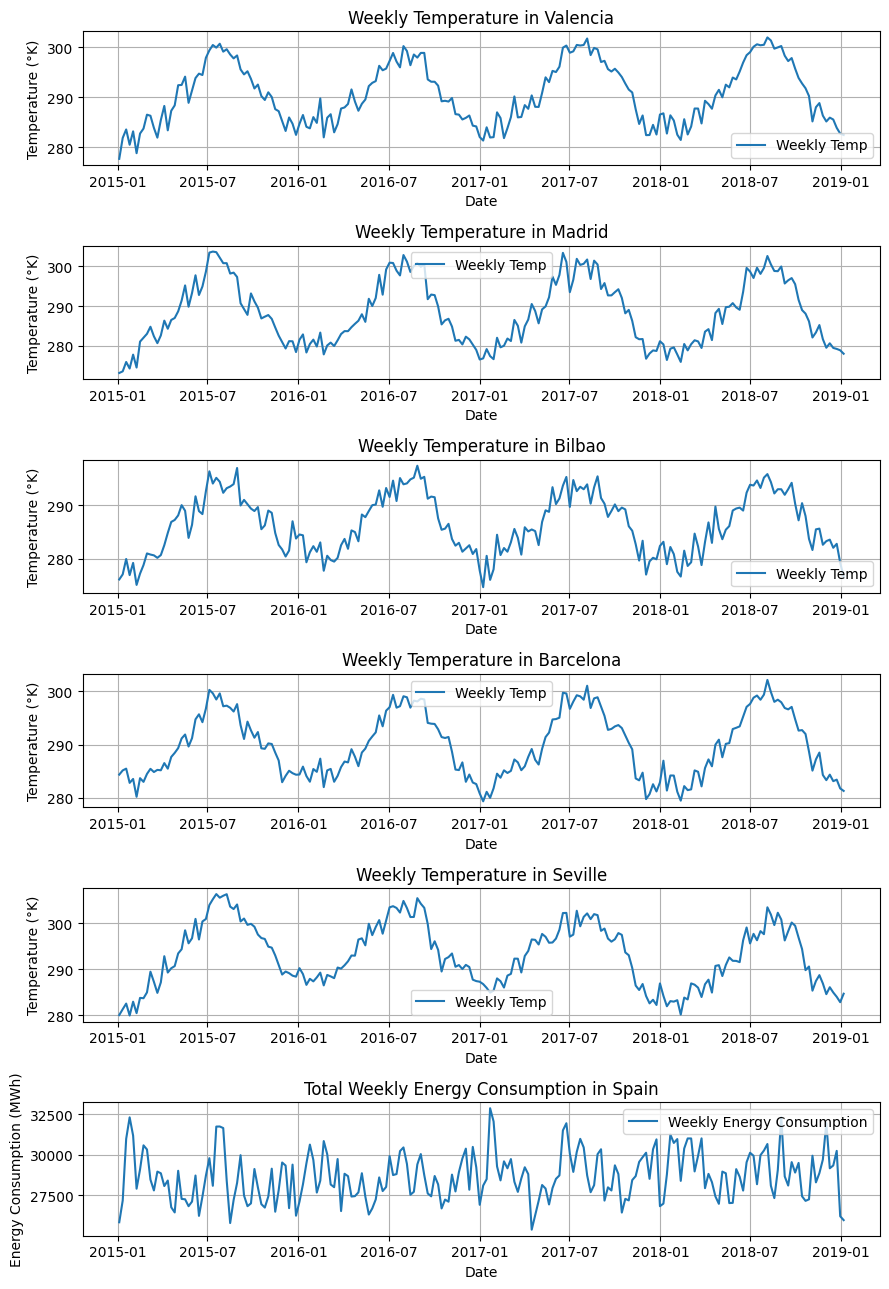

In [294]:
# Create a single figure with three subplots
fig, axs = plt.subplots(6, 1, figsize=(9, 13))

# Daily Valencia Temperature
axs[0].plot(weekly_df.index, weekly_df['temp_valencia'], label='Weekly Temp')
axs[0].set_title('Weekly Temperature in Valencia')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°K)')
axs[0].grid()
axs[0].legend()

# Daily Madrid Temperature
axs[1].plot(weekly_df.index, weekly_df['temp_madrid'], label='Weekly Temp')
axs[1].set_title('Weekly Temperature in Madrid')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°K)')
axs[1].grid()
axs[1].legend()

# Daily Bilbao Temperature
axs[2].plot(weekly_df.index, weekly_df['temp_bilbao'], label='Weekly Temp')
axs[2].set_title('Weekly Temperature in Bilbao')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature (°K)')
axs[2].grid()
axs[2].legend()

# Daily Barcelona Temperature
axs[3].plot(weekly_df.index, weekly_df['temp_barcelona'], label='Weekly Temp')
axs[3].set_title('Weekly Temperature in Barcelona')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Temperature (°K)')
axs[3].grid()
axs[3].legend()

# Daily Seville Temperature
axs[4].plot(weekly_df.index, weekly_df['temp_seville'], label='Weekly Temp')
axs[4].set_title('Weekly Temperature in Seville')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Temperature (°K)')
axs[4].grid()
axs[4].legend()

# Daily Total Energy Consumption of all of Spain
axs[5].plot(weekly_df.index, weekly_df['total load actual'], label='Weekly Energy Consumption')
axs[5].set_title('Total Weekly Energy Consumption in Spain')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Energy Consumption (MWh)')
axs[5].grid()
axs[5].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the conglomerated plot
plt.show()

Now, let's look at the monthly temperatures across all 5 cities and Spain as a whole.

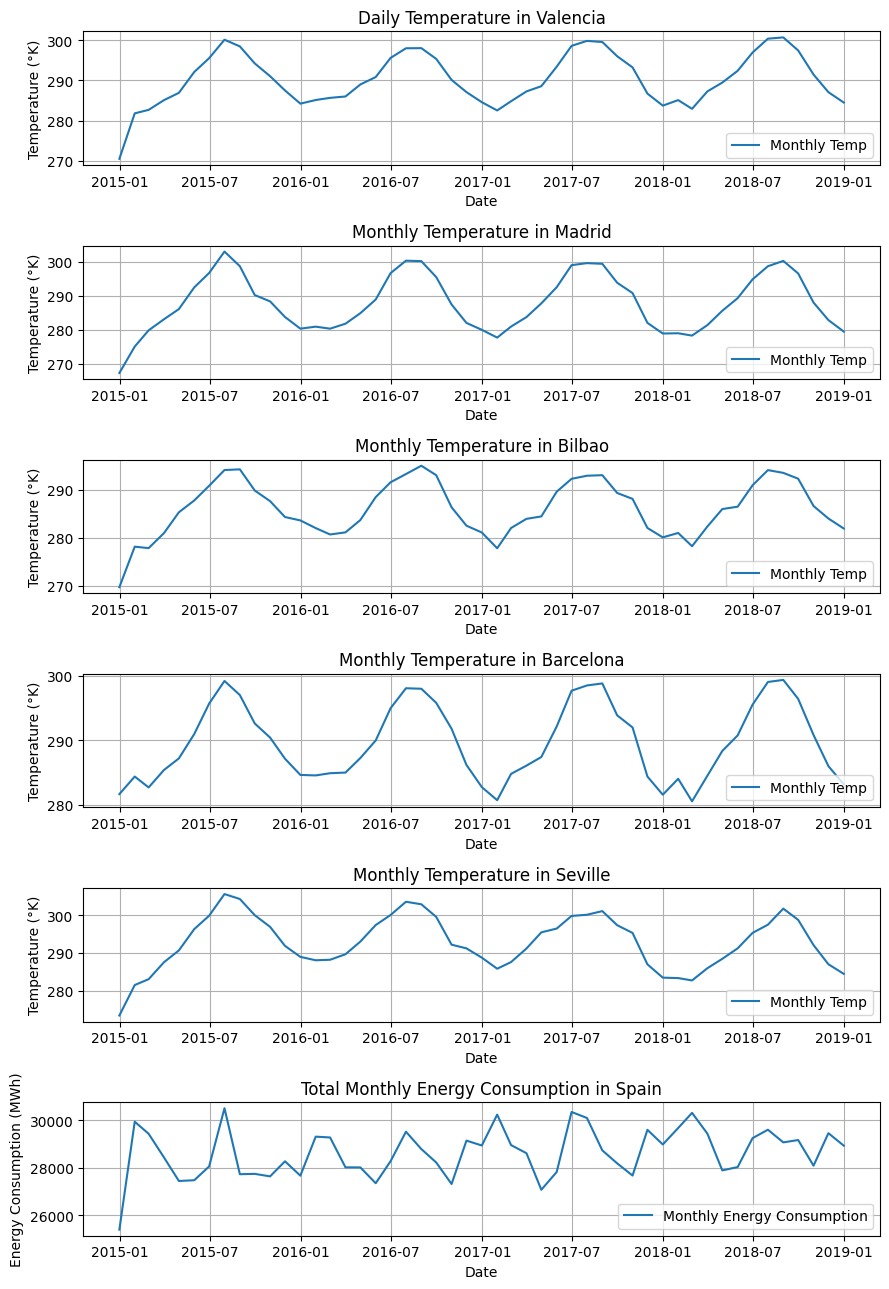

In [295]:
# Create a single figure with three subplots
fig, axs = plt.subplots(6, 1, figsize=(9, 13))

# Monthly Valencia Temperature
axs[0].plot(monthly_df.index, monthly_df['temp_valencia'], label='Monthly Temp')
axs[0].set_title('Daily Temperature in Valencia')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°K)')
axs[0].grid()
axs[0].legend()

# Monthly Madrid Temperature
axs[1].plot(monthly_df.index, monthly_df['temp_madrid'], label='Monthly Temp')
axs[1].set_title('Monthly Temperature in Madrid')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°K)')
axs[1].grid()
axs[1].legend()

# Monthly Bilbao Temperature
axs[2].plot(monthly_df.index, monthly_df['temp_bilbao'], label='Monthly Temp')
axs[2].set_title('Monthly Temperature in Bilbao')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature (°K)')
axs[2].grid()
axs[2].legend()

# Monthly Barcelona Temperature
axs[3].plot(monthly_df.index, monthly_df['temp_barcelona'], label='Monthly Temp')
axs[3].set_title('Monthly Temperature in Barcelona')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Temperature (°K)')
axs[3].grid()
axs[3].legend()

# Monthly Seville Temperature
axs[4].plot(monthly_df.index, monthly_df['temp_seville'], label='Monthly Temp')
axs[4].set_title('Monthly Temperature in Seville')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Temperature (°K)')
axs[4].grid()
axs[4].legend()

# Monthly Total Energy Consumption of all of Spain
axs[5].plot(monthly_df.index, monthly_df['total load actual'], label='Monthly Energy Consumption')
axs[5].set_title('Total Monthly Energy Consumption in Spain')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Energy Consumption (MWh)')
axs[5].grid()
axs[5].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the conglomerated plot
plt.show()


Now, let's look at the yearly temperatures across all 5 cities and Spain as a whole.

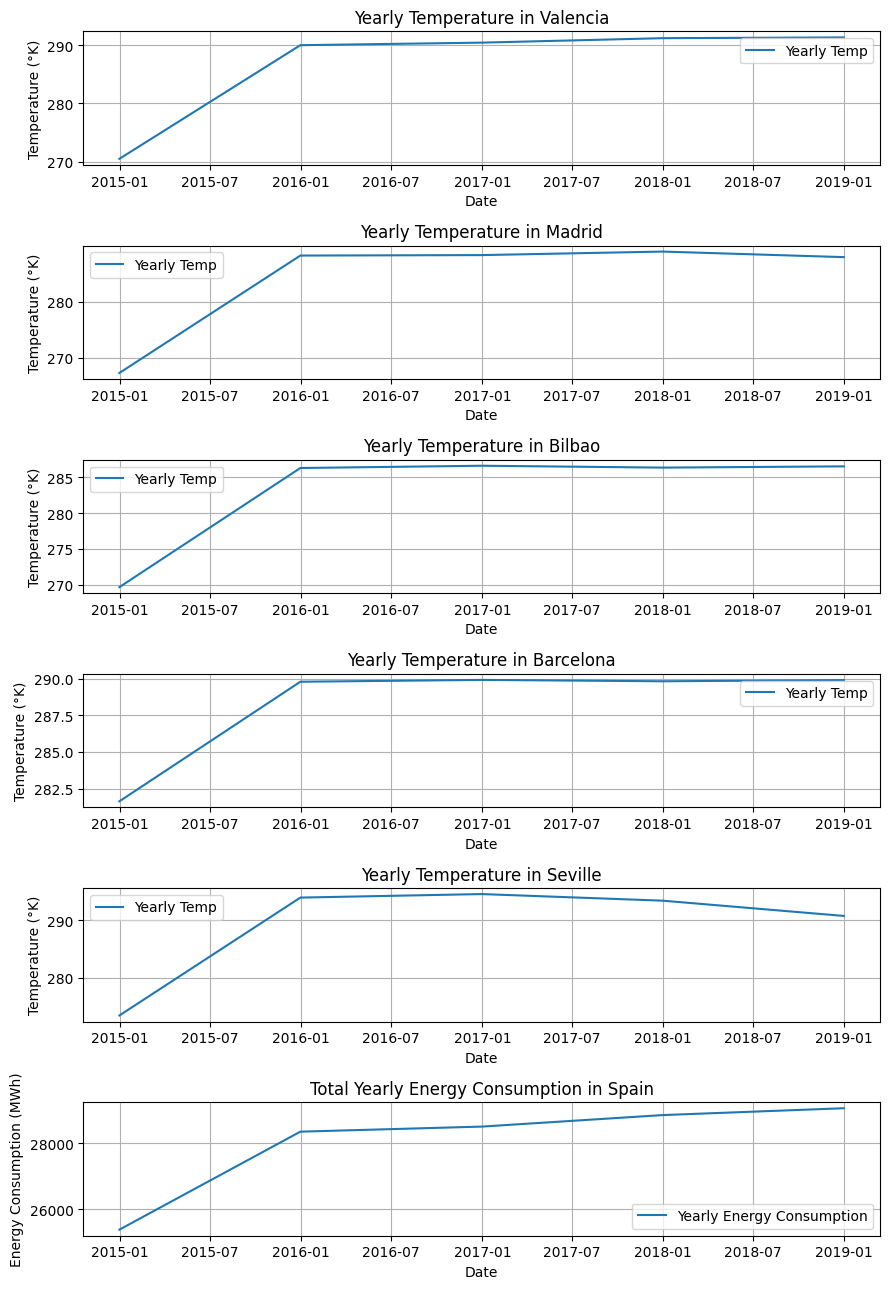

In [296]:
# VISUALIZATIONS FOR THE BINNED DATASETS

# Create a single figure with three subplots
fig, axs = plt.subplots(6, 1, figsize=(9, 13))

# Yearly Valencia Temperature
axs[0].plot(yearly_df.index, yearly_df['temp_valencia'], label='Yearly Temp')
axs[0].set_title('Yearly Temperature in Valencia')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°K)')
axs[0].grid()
axs[0].legend()

# Yearly Madrid Temperature
axs[1].plot(yearly_df.index, yearly_df['temp_madrid'], label='Yearly Temp')
axs[1].set_title('Yearly Temperature in Madrid')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°K)')
axs[1].grid()
axs[1].legend()

# Yearly Bilbao Temperature
axs[2].plot(yearly_df.index, yearly_df['temp_bilbao'], label='Yearly Temp')
axs[2].set_title('Yearly Temperature in Bilbao')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature (°K)')
axs[2].grid()
axs[2].legend()

# Yearly Barcelona Temperature
axs[3].plot(yearly_df.index, yearly_df['temp_barcelona'], label='Yearly Temp')
axs[3].set_title('Yearly Temperature in Barcelona')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Temperature (°K)')
axs[3].grid()
axs[3].legend()

# Yearly Seville Temperature
axs[4].plot(yearly_df.index, yearly_df['temp_seville'], label='Yearly Temp')
axs[4].set_title('Yearly Temperature in Seville')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Temperature (°K)')
axs[4].grid()
axs[4].legend()

# Yearly Total Energy Consumption of all of Spain
axs[5].plot(yearly_df.index, yearly_df['total load actual'], label='Yearly Energy Consumption')
axs[5].set_title('Total Yearly Energy Consumption in Spain')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Energy Consumption (MWh)')
axs[5].grid()
axs[5].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the conglomerated plot
plt.show()

We see that there is a sudden spike in 2016, and a steady increase until 2019. 
Global warming might've been especially significant between 2015-2016.